In [49]:
import pandas as pd
import numpy as np
from quetzal.model import stepmodel
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.messaging as message
from biogeme.expressions import Beta

# Inner-zonal trips
## Calibration and mode choice
Assignment of inner-zonal trips is not possible in this model. Trip lengths by mode and purpose must be approximated with MiD2017 data.

In [2]:
input_path = '/home/local/RL-INSTITUT/marlin.arnz/rli/Daten_flexibel_01/quetzal_germany/input/transport_demand/'
output_path = '/home/local/RL-INSTITUT/marlin.arnz/rli/Daten_flexibel_01/quetzal_germany/output/'
model_path = '/home/local/RL-INSTITUT/marlin.arnz/rli/Daten_flexibel_01/quetzal_germany/model/'

In [3]:
# Loading complete StepModel...
sm = stepmodel.read_zip(model_path + 'de_step_4.zip')

read_hdf: 100%|██████████| 43/43 [09:42<00:00, 13.54s/it]


## Calibration
The network model does not allow OD trips within zones. However, trip volumes and mode choice can depend on zonal attributes that are available in this represenation. These are:
* Population
* Area
* Urbanisation degree
* Number of PT stops by route type

### Model formulation
The model consists of observable utility functions, one for each mode j:
> V_i_j = ASC_j + b_pop_i_j * POP + b_area_i_j * AREA + b_urban_i_j * URBAN + b_stops_i_j * STOPS_j

Index i marks the demand group. I = {'work' (1), 'education' (2), 'shopping' (3), 'official' (4), 'private' (6)}

#### Enrich zones with PT stop data

In [4]:
sm.nodes['n_nodes'] = sm.nodes['names'].apply(lambda l: len(l))

In [7]:
stops = sm.nodes.groupby(['NUTS_ID', 'route_type']).agg({'n_nodes': 'sum'})

In [16]:
stops = stops.reset_index().pivot(index='NUTS_ID',
                                  columns='route_type',
                                  values='n_nodes').fillna(0)

In [17]:
sm.zones['STOPS_RAIL'] = sm.zones['NUTS_ID'].apply(lambda i: stops.loc[i, 'rail_short_distance']) \
    + sm.zones['NUTS_ID'].apply(lambda i: stops.loc[i, 'rail_long_distance'])
sm.zones['STOPS_BUS'] = sm.zones['NUTS_ID'].apply(lambda i: stops.loc[i, 'short_distance_traffic'])

In [18]:
sm.zones.head()

,CNTR_CODE,NUTS_NAME,LEVL_CODE,NUTS_ID,geometry,population,area,urbanisation,lau_id,STOPS_RAIL,STOPS_BUS
DE600,DE,Hamburg,3,DE600,"MULTIPOLYGON (((9.94538 53.65293, 9.95059 53.6...",1841179,755.09,1.0,2000,178.0,4383.0
DE711,DE,"Darmstadt, Kreisfreie Stadt",3,DE711,"POLYGON ((8.72571 49.95421, 8.73453 49.94858, ...",159207,122.07,1.0,6411,22.0,393.0
DE712,DE,"Frankfurt am Main, Kreisfreie Stadt",3,DE712,"POLYGON ((8.59024 50.15954, 8.58867 50.16843, ...",753056,248.31,1.0,6412,126.0,1554.0
DE713,DE,"Offenbach am Main, Kreisfreie Stadt",3,DE713,"POLYGON ((8.71783 50.06241, 8.73407 50.08527, ...",128744,44.88,1.0,6413,15.0,336.0
DE714,DE,"Wiesbaden, Kreisfreie Stadt",3,DE714,"POLYGON ((8.32765 50.14589, 8.32239 50.14425, ...",278342,203.87,1.0,6414,21.0,1009.0


#### Load trips table from MiD and filter

In [28]:
trips = pd.read_csv(input_path + 'MiD2017_Regional_Wege.csv', sep=';')
trips = trips[['KKZ_SO', 'KKZ_ZO', 'wegkm_imp','wegmin_imp1',
               'hwzweck1', 'hvm_diff2', 'auto', 'W_SO2']]
trips.columns = ['origin', 'destination', 'distance', 'duration',
                 'PURPOSE', 'MODE', 'CAR_AV', 'W_SO2']
trips['distance'] = pd.to_numeric(trips['distance'].str.replace(',', '.'))

In [29]:
# Filter for inner-German trips
trips = trips.loc[(trips['W_SO2']!=2) & (trips['W_SO2']!=3)]
# Filter unspecified rows
trips = trips.loc[(trips['origin']<9999) &
                  (trips['destination']<9999) &
                  (trips['PURPOSE']!=99) &
                  (trips['MODE']<24)]
print(trips.shape)

(409507, 9)


In [30]:
# Filter for inner-cell traffic
trips = trips.loc[trips['origin']==trips['destination']]
print(trips.shape)

(300620, 9)


In [31]:
# Remove air, coach and ferries
trips = trips.loc[trips['MODE']!=23]
trips = trips.loc[trips['MODE']!=19]
trips = trips.loc[trips['MODE']!=21]
trips = trips.loc[trips['MODE']!=22]
print(trips.shape)

(300133, 9)


In [32]:
# Match mode with the model modes
# Non-motorised modes are merged
mode_mid_vp_dict = {1:5, 2:5, 3:5, 4:2, 5:2, 6:2, 7:2, 8:2, 9:2, 10:2, 11:2, 12:4, 13:4, 14:4, 15:4, 16:1, 17:2, 18:2, 19:2, 20:1, 21:3, 22:3, 23:7, 24:5}
trips['MODE'] = trips['MODE'].map(mode_mid_vp_dict)

In [33]:
# Make car availability binary
trips['CAR_AV'] = trips['CAR_AV'].replace({9:0})
# Remove trips where mode is car but the car availability is zero
# because it irritates the MLE algorithm
trips = trips.loc[~((trips['MODE']==2) & (trips['CAR_AV']==0))]
print(trips.shape)

(297508, 9)


In [34]:
# Match trip purpose with VP2030 categories
# Note: Holiday trips are included in private (6)
purpose_mid_vp_dict = {1: 1, 2: 4, 3: 2, 4: 3, 5: 3, 6: 6, 7: 6, 99: 6}
trips['PURPOSE'] = trips['PURPOSE'].map(purpose_mid_vp_dict)

In [36]:
# Replace LAU IDs with NUTS IDs in origin and destination
nuts_to_lau = pd.ExcelFile('../input/network/zones/NUTS_to_LAU.xlsx').parse('DE')
nuts_to_lau['lau_id'] = nuts_to_lau['LAU CODE'].astype(str).str[:-3]
nuts_lau_dict = nuts_to_lau[['NUTS 3 CODE', 'lau_id']].set_index('lau_id').to_dict()['NUTS 3 CODE']
trips['origin'] = trips['origin'].astype(str).replace(nuts_lau_dict)
trips['destination'] = trips['destination'].astype(str).replace(nuts_lau_dict)

<AxesSubplot:title={'center':'Trip distance distribution, logarithmic'}, ylabel='Frequency'>

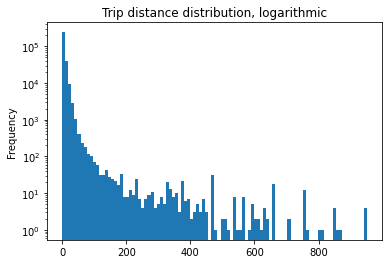

In [37]:
# Trip distance
trips['distance'].plot.hist(bins=100, log=True, title='Trip distance distribution, logarithmic')

<AxesSubplot:title={'center':'Trip duration distribution, logarithmic'}, ylabel='Frequency'>

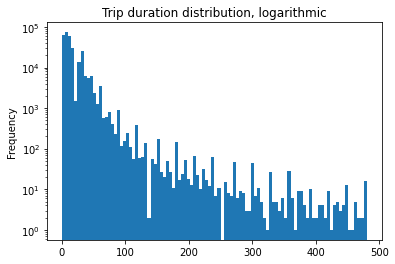

In [38]:
# Trip duration
trips['duration'].plot.hist(bins=100, log=True, title='Trip duration distribution, logarithmic')

<AxesSubplot:title={'center':'share of trips by purpose'}, ylabel='None'>

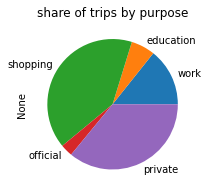

In [39]:
# Trip purpose
trips.groupby('PURPOSE').size().plot.pie(subplots=False,figsize=(3, 3),
                                         labels=['work', 'education', 'shopping', 'official', 'private'],
                                         title='share of trips by purpose')

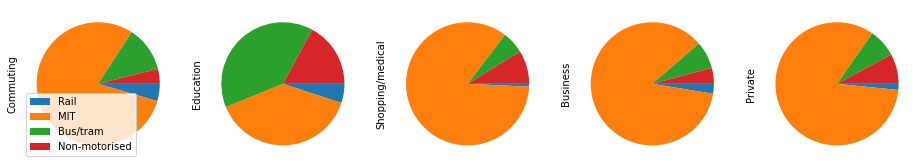

In [40]:
# Modal split
#import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#rli = ListedColormap(['#002E50', '#335873', '#668296', '#99ABB9', '#CCD5DC'])
axs = trips.groupby(['MODE','PURPOSE']).size().unstack(fill_value=0).rename(
    columns={1:'Commuting', 2:'Education', 3:'Shopping/medical', 4:'Business', 6:'Private'}).plot.pie(
    subplots=True, figsize=(16, 4), labels=['Rail', 'MIT', 'Bus/tram', 'Non-motorised'],
    startangle=0, counterclock=False,# colormap=rli,# title='Modal split by trip purpose',
    legend=False, labeldistance=None)
axs[0].legend()

#### Insert columns to trips

In [48]:
trips = trips.rename(columns={'origin':'NUTS_ID'}).merge(
    sm.zones[['STOPS_RAIL', 'STOPS_BUS', 'population', 'area', 'NUTS_ID', 'urbanisation']],
    on='NUTS_ID').rename(columns={'population':'POP', 'area':'AREA', 'urbanisation':'URBAN'})

In [51]:
trips = trips.drop(columns=['NUTS_ID', 'destination', 'duration', 'distance'])

#### Initialise the Biogeme model

In [52]:
database = db.Database('MiD', trips.copy())
globals().update(database.variables)
database.getSampleSize()

296992

In [53]:
# Define Betas
asc_rail = Beta('asc_rail', 0, None, None, 0)
asc_car = Beta('asc_car', 0, None, None, 1)
asc_bus = Beta('asc_bus', 0, None, None, 0)
asc_non_motor = Beta('asc_non_motor', 0, None, None, 0)
b_pop_rail = Beta('b_pop_rail', 0, None, None, 0)
b_area_rail = Beta('b_area_rail', 0, None, None, 0)
b_urban_rail = Beta('b_urban_rail', 0, None, None, 0)
b_stops_rail = Beta('b_stops_rail', 0, None, None, 0)
b_pop_car = Beta('b_pop_car', 0, None, None, 0)
b_area_car = Beta('b_area_car', 0, None, None, 0)
b_urban_car = Beta('b_urban_car', 0, None, None, 0)
b_pop_bus = Beta('b_pop_bus', 0, None, None, 0)
b_area_bus = Beta('b_area_bus', 0, None, None, 0)
b_urban_bus = Beta('b_urban_bus', 0, None, None, 0)
b_stops_bus = Beta('b_stops_bus', 0, None, None, 0)
b_pop_non_motor = Beta('b_pop_non_motor', 0, None, None, 0)
b_area_non_motor = Beta('b_area_non_motor', 0, None, None, 0)
b_urban_non_motor = Beta('b_urban_non_motor', 0, None, None, 0)

In [67]:
b_pop = Beta('b_pop', 0, None, None, 0)
b_area = Beta('b_area', 0, None, None, 0)
b_urban = Beta('b_urban', 0, None, None, 0)

In [54]:
# Parameters for the nested logit structure
mu_pt = Beta('mu_pt', 1, 1, 10, 0)

In [58]:
# Utility functions
V_RAIL = asc_rail + b_pop_rail * POP + b_area_rail * AREA + b_urban_rail * URBAN + b_stops_rail * STOPS_RAIL
V_CAR = asc_car + b_pop_car * POP + b_area_car * AREA + b_urban_car * URBAN
V_BUS = asc_bus + b_pop_bus * POP + b_area_bus * AREA + b_urban_bus * URBAN + b_stops_bus * STOPS_BUS
V_NON_MOTOR = asc_non_motor + b_pop_non_motor * POP + b_area_non_motor * AREA + b_urban_non_motor * URBAN

In [68]:
# Utility functions
V_RAIL = asc_rail + b_pop * POP + b_area * AREA + b_urban * URBAN + b_stops_rail * STOPS_RAIL
V_CAR = asc_car + b_pop * POP + b_area * AREA + b_urban * URBAN
V_BUS = asc_bus + b_pop * POP + b_area * AREA + b_urban * URBAN + b_stops_bus * STOPS_BUS
V_NON_MOTOR = asc_non_motor + b_pop * POP + b_area * AREA + b_urban * URBAN

In [56]:
# Define level of verbosity
logger = message.bioMessage()
#logger.setSilent()
logger.setWarning()
#logger.setGeneral()
#logger.setDetailed()

In [69]:
# Map modes to utility functions
V = {1:V_RAIL,
     2:V_CAR,
     4:V_BUS,
     5:V_NON_MOTOR}

In [60]:
# Map the availability of alternatives with MODE as key
# Except for the car, it is always one
av = {1:1,
      2:(CAR_AV==1),
      4:1,
      5:1}

In [61]:
# Mode nests as tuples with nest name and dictionary where
# alternative IDs are mapped to alpha values. Missing ID's alpha is zero
nests = ((mu_pt, [1, 4]), # PT
         (1, [2]), # Car
         (1, [5])) # Non-motorised

In [70]:
# Choose the logarithmic nested logit model
nl = models.lognested(V, av, nests, MODE)

In [71]:
# Write results to a file
writer = pd.ExcelWriter(input_path + 'estimation/estimation_results_inner_cell.xlsx', engine='xlsxwriter')

In [72]:
# Run all purposes
results = []
for p in [1, 2,3,4,6]:
    database = db.Database('MiD', trips.copy())
    database.remove(PURPOSE!=p)
    print('Sample size for purpose {}: {}'.format(p, database.getSampleSize()))
    model = bio.BIOGEME(database, nl) # Choose the model formulation
    model.modelName = 'NL_p' + str(p) # Name it
    results.append(model.estimate())
    output = results[-1].getEstimatedParameters()
    for key, val in results[-1].getGeneralStatistics().items():
        row = [val[0], val[1],'','','','','']
        if len(output.columns)>len(row): row.append('')
        output.loc[key] = row
    output.to_excel(writer, sheet_name=model.modelName)

Sample size for purpose 1: 42414


biogemeError: [-2.93451366e+00 -3.27530464e+00 -4.46636234e+00 -1.14221702e-06
  3.52581777e-04  4.38561872e-04  1.68587320e-02 -5.22827464e-09
  1.00000000e+00] is not feasible for the bounds [(-2.934513664784777, -2.934513664784776), (-3.275304642076927, -3.275304642076926), (-4.466362344738283, -4.466362344738283), (-1.1422170167982762e-06, -1.1422170161642509e-06), (0.00035258177677297323, 0.0003525817767736073), (0.00043856187182814057, 0.0004385618718287746), (0.016858732002223962, 0.016858732002224593), (-5.228272444991406e-09, -5.228271810966256e-09), (1.0, 1.0000000000000002)]

In [ ]:
writer.save()

### Run the NL for inner-cell traffic